In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import shap
import optuna
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [122]:
df= pd.read_csv('full_df.csv')

In [123]:
df = df.dropna(subset=['pv_for_trip.'])

In [124]:
X = df[['sex','age_group','spanish','driving_license_binary','educ_group','main_activity_group','prof_status_group','transport_card_binary','mobility_issue','ppl_hh','pp_4age_hh','vehicles_hh','private_parking.','electric.','trips_hh','primary_reason','distance_km','rush_hour_75.','travel_freq','pv_for_trip.','temp','precip']]
y = df[['primary_mode_group']]

In [111]:
categorical_cols = ['sex', 'age_group','spanish','driving_license_binary','educ_group','main_activity_group','prof_status_group','transport_card_binary','mobility_issue','private_parking.','electric.','primary_reason','pv_for_trip.']

In [125]:
X_dummies = pd.get_dummies(X, columns=categorical_cols)

In [126]:
# make sure categories start from 0
y['primary_mode_group'] = y['primary_mode_group'] - 1

/var/folders/ps/rsyy3fxx1fq6dzs0frkt8hl80000gn/T/ipykernel_12248/1151536143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['primary_mode_group'] = y['primary_mode_group'] - 1


In [127]:
rename_dict = {
    'rush_hour_75.' : 'rush_hour_75%',
    'ppl_hh': 'household_size',
    'pp_4age_hh': 'household_members_4plus',
    'vehicles_hh': 'household_vehicles',
    'trips_hh': 'household_trip_count',
    'sex_1': 'gender_male',
    'sex_2': 'gender_female',
    'age_group_1': 'age_below_18',
    'age_group_2': 'age_18_to_29',
    'age_group_3': 'age_30_to_59',
    'age_group_4': 'age_60plus',
    'spanish_1': 'spanish_nationality',
    'spanish_2': 'spanish_nationality_no',
    'driving_license_binary_0': 'has_driving_license_no',
    'driving_license_binary_1': 'has_driving_license',
    'educ_group_1': 'education_primary_or_less',
    'educ_group_2': 'education_secondary',
    'educ_group_3': 'education_bachelor_or_higher',
    'educ_group_4': 'education_other',
    'main_activity_group_1': 'main_activity_employed',
    'main_activity_group_2': 'main_activity_retired',
    'main_activity_group_3': 'main_activity_unemployed',
    'main_activity_group_4': 'main_activity_student',
    'prof_status_group_1': 'prof_status_public_employee',
    'prof_status_group_2': 'prof_status_private_employee',
    'prof_status_group_3': 'prof_status_own_or_family_business',
    'prof_status_group_4': 'prof_status_other',
    'prof_status_group_5': 'prof_status_unemployed',
    'transport_card_binary_0': 'has_transport_card_no',
    'transport_card_binary_1': 'has_transport_card_yes',
    'mobility_issue_1': 'mobility_issue',
    'mobility_issue_2': 'mobility_issue_no',
    'private_parking._0': 'private_parking_no',
    'private_parking._1': 'private_parking_yes',
    'electric._0': 'electric_or_hybrid_transport_no',
    'electric._1': 'electric_or_hybrid_transport',
    'primary_reason_1': 'trip_reason_work',
    'primary_reason_2': 'trip_reason_study',
    'primary_reason_3': 'trip_reason_entertainment',
    'primary_reason_4': 'trip_reason_accompany_others',
    'primary_reason_5': 'trip_reason_personal_matters',
    'primary_reason_6': 'trip_reason_other',
    'pv_for_trip._1.0':'private_vehicle_used',
    'pv_for_trip._2.0':'private_vehicle_used_no'
}

In [128]:
X_dummies = X_dummies.rename(columns=rename_dict)

In [129]:
X_dummies

,household_size,household_members_4plus,household_vehicles,household_trip_count,distance_km,rush_hour_75%,travel_freq,temp,precip,gender_male,...,electric_or_hybrid_transport_no,electric_or_hybrid_transport,trip_reason_work,trip_reason_study,trip_reason_entertainment,trip_reason_accompany_others,trip_reason_personal_matters,trip_reason_other,private_vehicle_used,private_vehicle_used_no
0,2,2,1,2,6.660582,1,1,14.1,0.000,True,...,True,False,True,False,False,False,False,False,True,False
1,2,2,1,2,6.660582,1,1,28.5,0.000,True,...,True,False,True,False,False,False,False,False,True,False
2,2,2,1,4,6.586497,1,1,14.4,0.000,True,...,True,False,True,False,False,False,False,False,True,False
3,2,2,1,4,6.586497,1,1,26.1,0.000,True,...,True,False,True,False,False,False,False,False,True,False
4,2,2,1,4,0.203441,0,1,19.5,0.000,False,...,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222739,2,2,3,7,0.708580,0,1,15.6,0.000,True,...,False,True,True,False,False,False,False,False,True,False
222740,2,2,3,7,3.237211,0,1,19.5,0.000,True,...,False,True,True,False,False,False,False,False,True,False
222741,2,2,3,7,2.769001,1,4,19.2,0.000,True,...,False,True,False,False,True,False,False,False,True,False
222742,2,2,3,7,3.893271,0,4,18.1,0.000,True,...,False,True,True,False,False,False,False,False,True,False


In [130]:
y = y.values.ravel()

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

In [132]:
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=20)

print("Best RF parameters:", rf_study.best_params)

[I 2025-04-09 14:18:29,462] A new study created in memory with name: no-name-3c89d144-7818-49f5-a14d-292794c8ebb9
[I 2025-04-09 14:21:45,916] Trial 0 finished with value: 0.721937165864424 and parameters: {'n_estimators': 492, 'max_depth': 14}. Best is trial 0 with value: 0.721937165864424.
[I 2025-04-09 14:25:21,568] Trial 1 finished with value: 0.7539155253121286 and parameters: {'n_estimators': 389, 'max_depth': 19}. Best is trial 1 with value: 0.7539155253121286.
[I 2025-04-09 14:26:01,581] Trial 2 finished with value: 0.6143485463516181 and parameters: {'n_estimators': 297, 'max_depth': 3}. Best is trial 1 with value: 0.7539155253121286.
[I 2025-04-09 14:27:25,935] Trial 3 finished with value: 0.7150938298217279 and parameters: {'n_estimators': 197, 'max_depth': 13}. Best is trial 1 with value: 0.7539155253121286.
[I 2025-04-09 14:28:34,737] Trial 4 finished with value: 0.7468669352489377 and parameters: {'n_estimators': 120, 'max_depth': 18}. Best is trial 1 with value: 0.7539155

Best RF parameters: {'n_estimators': 450, 'max_depth': 20}


In [133]:
def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    
    model = XGBClassifier(
        objective='multi:softprob',
        num_class = len(np.unique(y)),
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        eval_metric='mlogloss',
        random_state=42
    )
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=20)
print("Best XGB params:", xgb_study.best_params)

[I 2025-04-09 16:32:09,639] A new study created in memory with name: no-name-adecc63d-33ae-41c0-bf53-b2cfcb17ee36
[I 2025-04-09 16:36:26,209] Trial 0 finished with value: 0.7705075764532539 and parameters: {'n_estimators': 263, 'max_depth': 20, 'learning_rate': 0.09489546678635637}. Best is trial 0 with value: 0.7705075764532539.
[I 2025-04-09 16:42:01,003] Trial 1 finished with value: 0.7698469814819144 and parameters: {'n_estimators': 405, 'max_depth': 17, 'learning_rate': 0.07208490471021417}. Best is trial 0 with value: 0.7705075764532539.
[I 2025-04-09 16:43:28,668] Trial 2 finished with value: 0.7187046941418183 and parameters: {'n_estimators': 372, 'max_depth': 5, 'learning_rate': 0.1871585575559784}. Best is trial 0 with value: 0.7705075764532539.
[I 2025-04-09 16:46:04,398] Trial 3 finished with value: 0.7530496956536898 and parameters: {'n_estimators': 389, 'max_depth': 10, 'learning_rate': 0.15805584996877722}. Best is trial 0 with value: 0.7705075764532539.
[I 2025-04-09 16

Best XGB params: {'n_estimators': 246, 'max_depth': 20, 'learning_rate': 0.1078221902079666}


In [134]:
#Train final models with best hyperparameters 
best_rf = RandomForestClassifier(**rf_study.best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Final RF accuracy:", rf_accuracy)

best_xgb = XGBClassifier(
    **xgb_study.best_params,
    objective='multi:softprob',
    num_class = len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42
)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("Final XGB accuracy:", xgb_accuracy)

Final RF accuracy: 0.7690465857564013
Final XGB accuracy: 0.7881717372760876


In [135]:
#Model performance weights
rf_f1 = f1_score(y_test, best_rf.predict(X_test), average='macro')
xgb_f1 = f1_score(y_test, best_xgb.predict(X_test), average='macro')

rf_weight = rf_f1 / (rf_f1 + xgb_f1)
xgb_weight = xgb_f1 / (rf_f1 + xgb_f1)

print(f" F1 score: {rf_f1:.4f}, XGB F1 score: {xgb_f1:.4f}")
print(f"RF weight: {rf_weight:.4f}, XGB weight: {xgb_weight:.4f}")

 F1 score: 0.5761, XGB F1 score: 0.6293
RF weight: 0.4780, XGB weight: 0.5220


In [136]:
#Use a sub sample representative enough for time reasons 
X_test_sample = X_test.sample(n=3000, random_state=42)

In [137]:
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_test_sample)

In [138]:
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_sample)

SHAP PER CLASS COMBINED XGB AND RF

Summary plot for class 0:


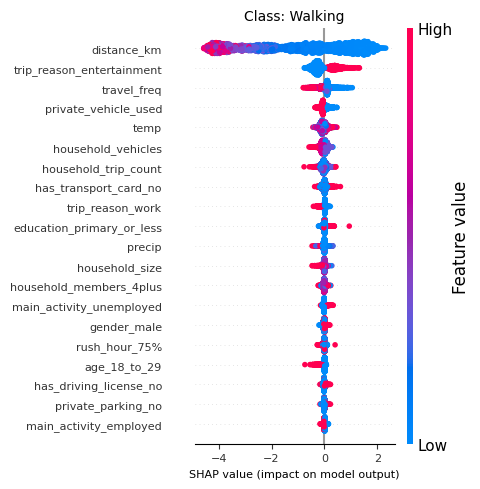

Summary plot for class 1:


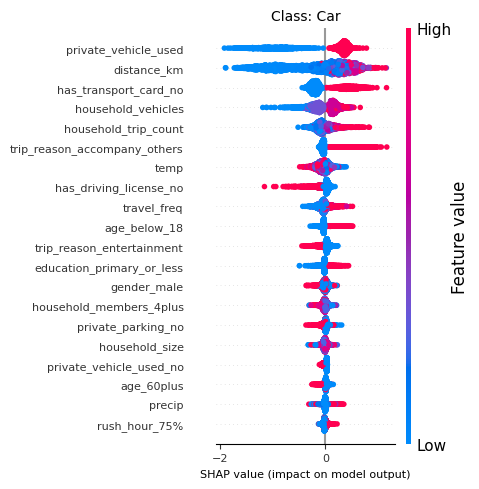

Summary plot for class 2:


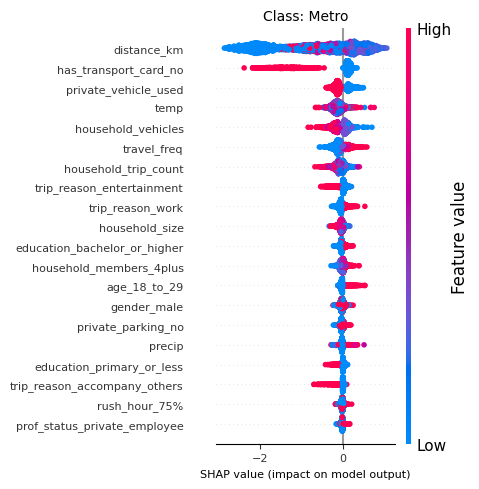

Summary plot for class 3:


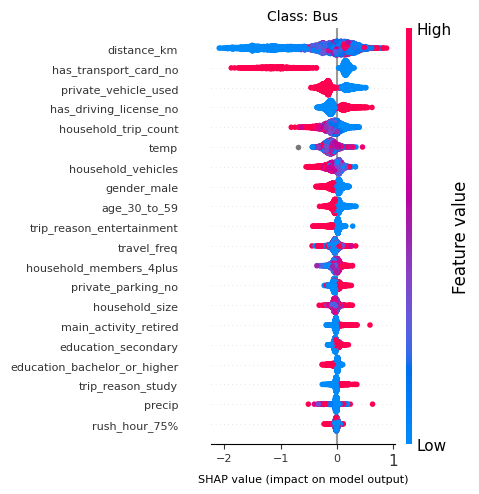

Summary plot for class 4:


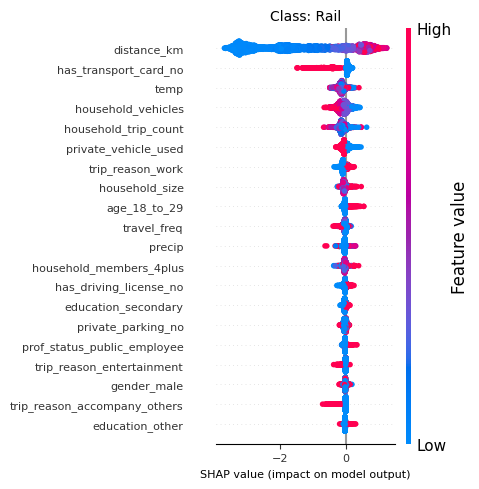

Summary plot for class 5:


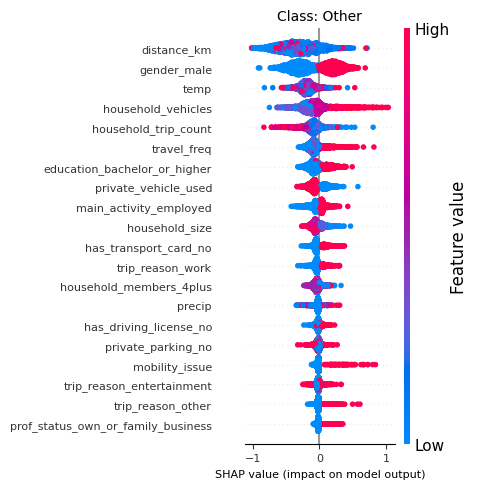

In [139]:
n_classes = shap_values_rf.shape[2]
class_names = ['Walking',"Car",'Metro', 'Bus','Rail','Other']
for c in range(n_classes):
    shap_rf_c = shap_values_rf[:, :, c]
    shap_xgb_c = shap_values_xgb[:, :, c]
    
    combined_shap_c = rf_weight *  shap_rf_c + xgb_weight * shap_xgb_c
    
    print(f"Summary plot for class {c}:")
    shap.summary_plot(combined_shap_c, X_test_sample, feature_names=X_test_sample.columns, plot_type="dot", show=False,plot_size=(5,5))
    class_name = class_names[c]
    plt.title(f"Class: {class_name}", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel("SHAP value (impact on model output)", fontsize=8)
    plt.tight_layout()
    plt.show()

GLOBAL SHAP 

In [140]:
# use predicted probabilities for each class as weights for per-class SHAP values
p_rf = best_rf.predict_proba(X_test_sample)
p_xgb = best_xgb.predict_proba(X_test_sample)
p_rf_reshaped = p_rf[:, None, :]  
p_xgb_reshaped = p_xgb[:, None, :]

In [141]:
phi_rf_weighted = rf_weight * p_rf_reshaped * shap_values_rf 
phi_xgb_weighted = xgb_weight * p_xgb_reshaped * shap_values_xgb

In [142]:
phi_combined = phi_rf_weighted + phi_xgb_weighted
phi_combined_abs = np.abs(phi_combined)
phi_summed_over_classes = np.sum(phi_combined_abs, axis=2)

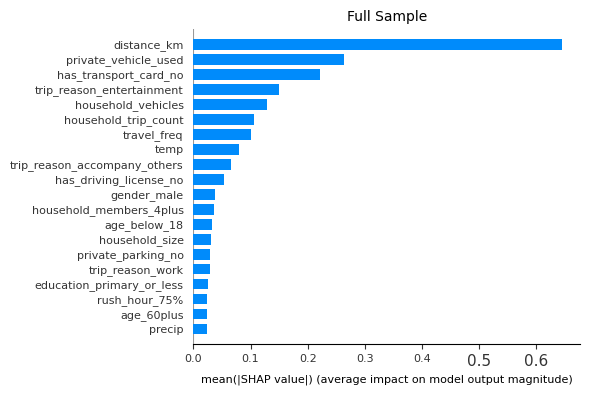

In [143]:
shap.summary_plot(phi_summed_over_classes, X_test_sample, feature_names=X_test_sample.columns, plot_type="bar", plot_size=(6,4), show=False)
plt.title("Full Sample", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)", fontsize=8)
plt.tight_layout()
plt.show()